In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import pandas as pd
from shutil import copyfile
import sys
sys.path.insert(0, '')

'''
import spde.spde_2d_simulations

import poisson_process.poisson_process_simulation

import filtering.observations_module
import filtering.enkf_module
import filtering.filter_module
'''
#import tools.tools_spde as tools_spde
import utils.tools.tools_spde as tools_spde
import utils.tools.tools_os as tools_os
import utils.tools.tools_mpp as tools_mpp
import utils.tools.tools_filtering as tools_filtering

# Section 5.1

## Static signal

### Go to working_dir with all csv data in it

In [27]:
working_dir_parent = os.path.join(os.getcwd(), "simulations")
source_dir_id = "static_signal_source"

# enter name for saving simulations
working_dir_id = "static_signal_2"

In [28]:
os.makedirs(os.path.join(working_dir_parent, working_dir_id), exist_ok= True)
source_dir = tools_os.return_working_dir_folders(working_dir_parent, source_dir_id, create_dir= False)
working_dir = tools_os.return_working_dir_folders(working_dir_parent, working_dir_id, create_dir= False)

In [29]:
tools_os.export_all_signal_and_observation_csv_data(source_dir, working_dir, export_from_folders=False)

In [30]:
tools_os.create_working_dir_tree_and_csv_data_from_run_csv(working_dir)

In [31]:
tools_filtering.simulate_and_save_signal_and_observations_in_working_dir(working_dir)

  0%|          | 0/3999 [00:00<?, ?it/s]

100%|██████████| 3999/3999 [00:00<00:00, 4088.02it/s]


Load all observation directories

In [32]:
observation_dirs = tools_filtering.return_observation_dirs_as_dict(working_dir)

In [33]:
observation_dirs

{'O1': '/home/jszala/Insync/jan.szalankiewicz@gmail.com/Google Drive/Work/Coding/git/SPDE_Poisson_filtering/simulations/static_signal_2/observations/O1',
 'O1_2_partial_center': '/home/jszala/Insync/jan.szalankiewicz@gmail.com/Google Drive/Work/Coding/git/SPDE_Poisson_filtering/simulations/static_signal_2/observations/O1/downscaled/2_partial_center',
 'O1_4_partial_center': '/home/jszala/Insync/jan.szalankiewicz@gmail.com/Google Drive/Work/Coding/git/SPDE_Poisson_filtering/simulations/static_signal_2/observations/O1/downscaled/4_partial_center',
 'O1_8_partial_center': '/home/jszala/Insync/jan.szalankiewicz@gmail.com/Google Drive/Work/Coding/git/SPDE_Poisson_filtering/simulations/static_signal_2/observations/O1/downscaled/8_partial_center',
 'O1_2_sum': '/home/jszala/Insync/jan.szalankiewicz@gmail.com/Google Drive/Work/Coding/git/SPDE_Poisson_filtering/simulations/static_signal_2/observations/O1/downscaled/2_sum',
 'O1_4_sum': '/home/jszala/Insync/jan.szalankiewicz@gmail.com/Google Dri

In [34]:
observation_ids = list(observation_dirs.keys())

### Signal

#### Loading signal metaparameters

In [35]:
dt, dx, timesteps, dim_x, dim_y, eulerstep_type = tools_spde.load_spde_metadata(working_dir)

dim_x = int(dim_x)
dim_y = int(dim_y)
timesteps = int(timesteps)

#### Loading signal arguments for filter

In [36]:
signal_path = tools_filtering.load_signal_path(working_dir)
signal_path_plot = tools_spde.return_path_for_2d_plotting(signal_path, timesteps, dim_x, dim_y)

<Axes: >

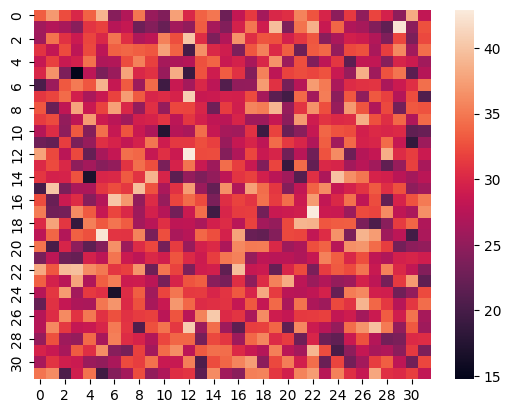

In [37]:
sns.heatmap(signal_path_plot[900])

### Filtering

In [15]:
# set string as id 
estimator_id = "E1"

In [16]:
# copy signal_parameters into estimator directory
tools_filtering.copy_spde_parameters_to_filtering_dir(working_dir, estimator_id)

#### Save Initial condition for filter

In [17]:
# Create a random intital condition

spde_type = tools_spde.load_spde_type(working_dir)

if spde_type == "heat":
    spde_path = tools_spde.load_spde_path(working_dir,  spde_type = spde_type)
    initial_condition_signal = spde_path.mean()*np.ones([dim_x*dim_y])
    initial_condition_signal_variance = spde_path.var()*np.eye(dim_x*dim_y)

    tools_filtering.save_signal_initital_condition_args(working_dir, estimator_id, initial_condition_signal, initial_condition_signal_variance)

elif spde_type == "fitzhugh_nagumo":
    
    act_path, inh_path = tools_spde.load_spde_path(working_dir,  spde_type = spde_type)
    
    initial_condition_act = act_path[0:100].mean()*np.ones([dim_x*dim_y]) 
    initial_condition_inh = inh_path[0:100].mean()*np.ones([dim_x*dim_y])

    initial_condition_act_variance = 0.1*act_path.var()*np.eye(dim_x*dim_y)
    initial_condition_inh_variance = 0.1*inh_path.var()*np.eye(dim_x*dim_y)

    tools_filtering.save_signal_initital_condition_args(working_dir, estimator_id, [initial_condition_act, initial_condition_inh], [initial_condition_act_variance, initial_condition_inh_variance])

Signal model parameters

In [18]:
signal_param_temp = tools_filtering.return_signal_args_for_filtering(working_dir, estimator_id)

signal_type = signal_param_temp[0]
implicit_bool = signal_param_temp[1]
signal_args = signal_param_temp[2:]

### Loading Observation

In [19]:
# choose observation_id
k = 0
print(observation_ids[k])


O1


In [20]:
# load corresponding directory
observation_dir = observation_dirs[observation_ids[0]]

In [21]:
time_multiplier, spatial_multiplier, timesteps_obs, dt_obs, dx_obs, dim_x_obs, dim_y_obs  = tools_filtering.load_observation_metadata_from_dir(observation_dir)

timesteps_obs = int(timesteps_obs)
dim_x_obs = int(dim_x_obs)
dim_y_obs = int(dim_y_obs)

In [22]:
observation_path = tools_filtering.load_observation_path_from_dir(observation_dir)
observation_path_plot = tools_spde.return_path_for_2d_plotting(observation_path, timesteps_obs, dim_x_obs, dim_y_obs)

### Run particle filter

In [23]:
ensemble_size = 5

In [24]:
estimate = tools_filtering.run_particle_filter_with_estimator_id(working_dir, observation_dir, estimator_id, ensemble_size, print_steps=True, save_simulation=True)

100%|██████████| 3999/3999 [05:49<00:00, 11.45it/s]


In [25]:
estimate_plot = tools_spde.return_path_for_2d_plotting(estimate, timesteps_obs, dim_x, dim_y)

Text(0.5, 1.0, 'Particle filter estimate')

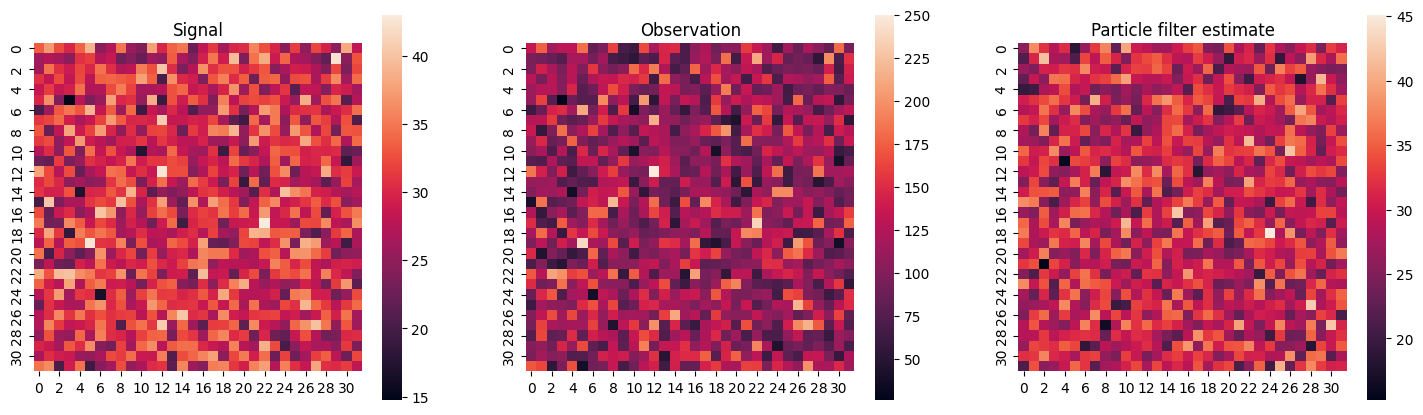

In [26]:
timestep = 3980

fig, ax = plt.subplots(1,3, figsize = (18,5))

sns.heatmap(signal_path_plot[int(timestep*time_multiplier)], ax= ax[0], square = True)
ax[0].set_title("Signal")
sns.heatmap(observation_path_plot[timestep]-observation_path_plot[timestep-1], ax= ax[1], square = True)
ax[1].set_title("Observation")
sns.heatmap(estimate_plot[timestep], ax= ax[2], square = True)
ax[2].set_title("Particle filter estimate")

## Static signal

### Go to working_dir with all csv data in it

In [ ]:
working_dir_parent = os.path.join(os.getcwd(), "simulations")
source_dir_id = "static_signal_source"

# enter name for saving simulations
working_dir_id = "static_signal_2"

In [ ]:
os.makedirs(os.path.join(working_dir_parent, working_dir_id), exist_ok= True)
source_dir = tools_os.return_working_dir_folders(working_dir_parent, source_dir_id, create_dir= False)
working_dir = tools_os.return_working_dir_folders(working_dir_parent, working_dir_id, create_dir= False)

In [ ]:
tools_os.export_all_signal_and_observation_csv_data(source_dir, working_dir, export_from_folders=False)

In [ ]:
tools_os.create_working_dir_tree_and_csv_data_from_run_csv(working_dir)

In [ ]:
tools_filtering.simulate_and_save_signal_and_observations_in_working_dir(working_dir)

  0%|          | 0/3999 [00:00<?, ?it/s]

100%|██████████| 3999/3999 [00:00<00:00, 4088.02it/s]


Load all observation directories

In [ ]:
observation_dirs = tools_filtering.return_observation_dirs_as_dict(working_dir)

In [ ]:
observation_dirs

{'O1': '/home/jszala/Insync/jan.szalankiewicz@gmail.com/Google Drive/Work/Coding/git/SPDE_Poisson_filtering/simulations/static_signal_2/observations/O1',
 'O1_2_partial_center': '/home/jszala/Insync/jan.szalankiewicz@gmail.com/Google Drive/Work/Coding/git/SPDE_Poisson_filtering/simulations/static_signal_2/observations/O1/downscaled/2_partial_center',
 'O1_4_partial_center': '/home/jszala/Insync/jan.szalankiewicz@gmail.com/Google Drive/Work/Coding/git/SPDE_Poisson_filtering/simulations/static_signal_2/observations/O1/downscaled/4_partial_center',
 'O1_8_partial_center': '/home/jszala/Insync/jan.szalankiewicz@gmail.com/Google Drive/Work/Coding/git/SPDE_Poisson_filtering/simulations/static_signal_2/observations/O1/downscaled/8_partial_center',
 'O1_2_sum': '/home/jszala/Insync/jan.szalankiewicz@gmail.com/Google Drive/Work/Coding/git/SPDE_Poisson_filtering/simulations/static_signal_2/observations/O1/downscaled/2_sum',
 'O1_4_sum': '/home/jszala/Insync/jan.szalankiewicz@gmail.com/Google Dri

In [ ]:
observation_ids = list(observation_dirs.keys())

### Signal

#### Loading signal metaparameters

In [ ]:
dt, dx, timesteps, dim_x, dim_y, eulerstep_type = tools_spde.load_spde_metadata(working_dir)

dim_x = int(dim_x)
dim_y = int(dim_y)
timesteps = int(timesteps)

#### Loading signal arguments for filter

In [ ]:
signal_path = tools_filtering.load_signal_path(working_dir)
signal_path_plot = tools_spde.return_path_for_2d_plotting(signal_path, timesteps, dim_x, dim_y)

<Axes: >

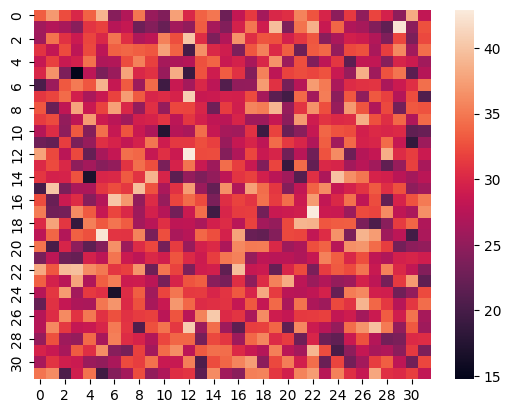

In [ ]:
sns.heatmap(signal_path_plot[900])

### Filtering

In [ ]:
# set string as id 
estimator_id = "E1"

In [ ]:
# copy signal_parameters into estimator directory
tools_filtering.copy_spde_parameters_to_filtering_dir(working_dir, estimator_id)

#### Save Initial condition for filter

In [ ]:
# Create a random intital condition

spde_type = tools_spde.load_spde_type(working_dir)

if spde_type == "heat":
    spde_path = tools_spde.load_spde_path(working_dir,  spde_type = spde_type)
    initial_condition_signal = spde_path.mean()*np.ones([dim_x*dim_y])
    initial_condition_signal_variance = spde_path.var()*np.eye(dim_x*dim_y)

    tools_filtering.save_signal_initital_condition_args(working_dir, estimator_id, initial_condition_signal, initial_condition_signal_variance)

elif spde_type == "fitzhugh_nagumo":
    
    act_path, inh_path = tools_spde.load_spde_path(working_dir,  spde_type = spde_type)
    
    initial_condition_act = act_path[0:100].mean()*np.ones([dim_x*dim_y]) 
    initial_condition_inh = inh_path[0:100].mean()*np.ones([dim_x*dim_y])

    initial_condition_act_variance = 0.1*act_path.var()*np.eye(dim_x*dim_y)
    initial_condition_inh_variance = 0.1*inh_path.var()*np.eye(dim_x*dim_y)

    tools_filtering.save_signal_initital_condition_args(working_dir, estimator_id, [initial_condition_act, initial_condition_inh], [initial_condition_act_variance, initial_condition_inh_variance])

Signal model parameters

In [ ]:
signal_param_temp = tools_filtering.return_signal_args_for_filtering(working_dir, estimator_id)

signal_type = signal_param_temp[0]
implicit_bool = signal_param_temp[1]
signal_args = signal_param_temp[2:]

### Loading Observation

In [ ]:
# choose observation_id
k = 0
print(observation_ids[k])


O1


In [ ]:
# load corresponding directory
observation_dir = observation_dirs[observation_ids[0]]

In [ ]:
time_multiplier, spatial_multiplier, timesteps_obs, dt_obs, dx_obs, dim_x_obs, dim_y_obs  = tools_filtering.load_observation_metadata_from_dir(observation_dir)

timesteps_obs = int(timesteps_obs)
dim_x_obs = int(dim_x_obs)
dim_y_obs = int(dim_y_obs)

In [ ]:
observation_path = tools_filtering.load_observation_path_from_dir(observation_dir)
observation_path_plot = tools_spde.return_path_for_2d_plotting(observation_path, timesteps_obs, dim_x_obs, dim_y_obs)

### Run particle filter

In [ ]:
ensemble_size = 5

In [ ]:
estimate = tools_filtering.run_particle_filter_with_estimator_id(working_dir, observation_dir, estimator_id, ensemble_size, print_steps=True, save_simulation=True)

100%|██████████| 3999/3999 [05:49<00:00, 11.45it/s]


In [ ]:
estimate_plot = tools_spde.return_path_for_2d_plotting(estimate, timesteps_obs, dim_x, dim_y)

Text(0.5, 1.0, 'Particle filter estimate')

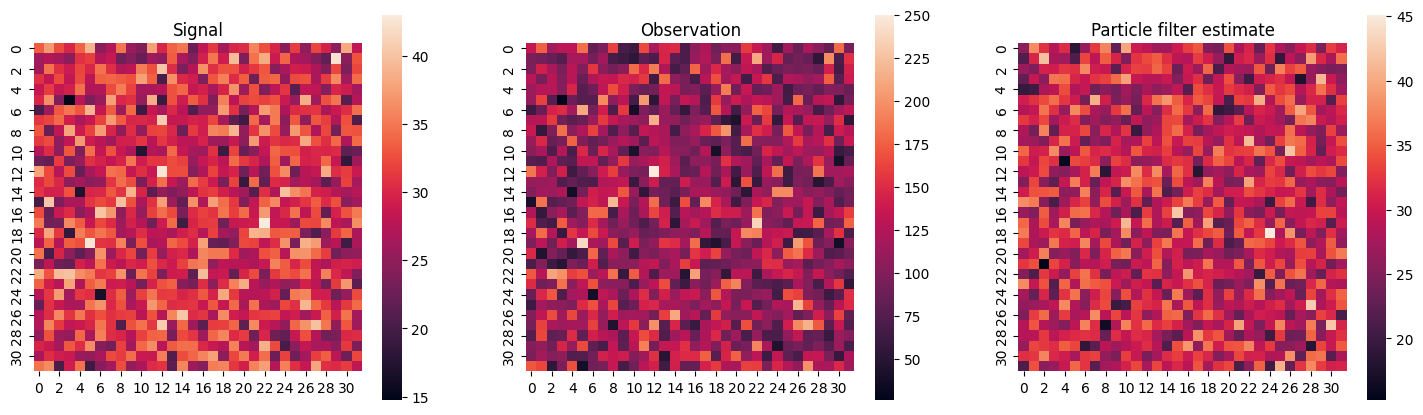

In [ ]:
timestep = 3980

fig, ax = plt.subplots(1,3, figsize = (18,5))

sns.heatmap(signal_path_plot[int(timestep*time_multiplier)], ax= ax[0], square = True)
ax[0].set_title("Signal")
sns.heatmap(observation_path_plot[timestep]-observation_path_plot[timestep-1], ax= ax[1], square = True)
ax[1].set_title("Observation")
sns.heatmap(estimate_plot[timestep], ax= ax[2], square = True)
ax[2].set_title("Particle filter estimate")